# To do

+ fill template
+ plot distribution of numeric variables
+ compute V cramer and R² of each variable
+ plot ordered V cramer and R² of each variable

# --------------------------------------Session--------------------------------------

In [ ]:
# install modules
pip install dill

In [ ]:
# Option 2
python -m install dill

In [1]:
# import modules
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dill

%matplotlib inline

In [2]:
##### Defining directory
os.chdir('C:\\Users\\Megaport\\20220814_projectDS')
os.chdir('C:\\Users\\Megaport\\Desktop\\jupyterNotebook')
os.getcwd()

'C:\\Users\\Megaport\\Desktop\\jupyterNotebook'

In [3]:
# import session
dill.load_session('notebook_env.db')

In [98]:
# save session
dill.dump_session('notebook_env.db')

# --------------------------------------Import--------------------------------------

In [7]:
##### Import of tables into dataframes
dfLieux = pd.read_csv('20220817_table_lieux.csv', sep=',')
dfUsagers = pd.read_csv('20220814_table_usagers.csv', sep=',')
dfVehicules = pd.read_csv('20220817_table_vehicules.csv', sep=',')
dfCarac = pd.read_csv('20220817_table_caracteristiques.csv', sep=',')

##### Merging of tables into 1 pooled dataframe
# dfPool = pd.merge(dfLieux, dfUsagers, dfVehicules, dfCarac, on="Num_Acc")

C:\Users\Megaport\AppData\Local\Temp\ipykernel_15708\890290328.py:2: DtypeWarning: Columns (4,9,10,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  dfLieux = pd.read_csv('20220817_table_lieux.csv', sep=',')
C:\Users\Megaport\AppData\Local\Temp\ipykernel_15708\890290328.py:3: DtypeWarning: Columns (9,13) have mixed types. Specify dtype option on import or set low_memory=False.
  dfUsagers = pd.read_csv('20220814_table_usagers.csv', sep=',')
C:\Users\Megaport\AppData\Local\Temp\ipykernel_15708\890290328.py:4: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  dfVehicules = pd.read_csv('20220817_table_vehicules.csv', sep=',')
C:\Users\Megaport\AppData\Local\Temp\ipykernel_15708\890290328.py:5: DtypeWarning: Columns (6,12,14,15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  dfCarac = pd.read_csv('20220817_table_caracteristiques.csv', sep=',')


In [8]:
print('dfLieux dimensions:', dfLieux.shape)
print('dfUsagers dimensions:', dfUsagers.shape)
print('dfVehicules dimensions:', dfVehicules.shape)
print('dfCarac dimensions:', dfCarac.shape)
# print('dfPool dimensions:', dfPool.shape)

dfLieux dimensions: (1065053, 22)
dfUsagers dimensions: (2380467, 17)
dfVehicules dimensions: (1817587, 14)
dfCarac dimensions: (1065053, 19)


# --------------------------------------Data-management--------------------------------------

In [9]:
# Computing date variable
dfCarac['date'] = dfCarac['jour'].astype(str) + '-' + dfCarac['mois'].astype(str) + '-' + dfCarac['an'].astype(str)
dfCarac['date'] = pd.to_datetime(dfCarac['date']);

# Computing months with categorical labels
dfCarac['mois_label'] = dfCarac['mois']
dfCarac['mois_label'] = dfCarac['mois_label'].replace(to_replace=np.arange(1, 13, 1), 
                                                      value=['jan', 'fev', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'])

# Days of the week
dfCarac['weekday'] = dfCarac['date'].dt.weekday

# Hour of the day
dfCarac['hrmn'] = dfCarac['hrmn'].replace('\:', '', regex=True).astype(int)
dfCarac['hour'] = dfCarac['hrmn']//100

# Year of accident
dfCarac['year'] = dfCarac['date'].dt.year

C:\Users\Megaport\anaconda3\lib\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning: Parsing '30-11-2019' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
C:\Users\Megaport\anaconda3\lib\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning: Parsing '28-11-2019' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
C:\Users\Megaport\anaconda3\lib\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning: Parsing '29-11-2019' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
C:\Users\Megaport\anaconda3\lib\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning: Parsing '27-11-2019' in DD/MM/YYYY format. Provide form

In [10]:
dfCarac['date'].value_counts().sort_index()

2005-01-01    180
2005-01-02    209
2005-01-03    185
2005-01-04    289
2005-01-05    241
             ... 
2020-12-27     55
2020-12-28    109
2020-12-29     86
2020-12-30    119
2020-12-31     94
Name: date, Length: 5844, dtype: int64

In [11]:
dfCarac['year'].value_counts().sort_index()

2005    87026
2006    82993
2007    83850
2008    76767
2009    74409
2010    69379
2011    66974
2012    62250
2013    58397
2014    59854
2015    58654
2016    59432
2017    60701
2018    57783
2019    58840
2020    47744
Name: year, dtype: int64

# --------------------------------------Descriptive statistics--------------------------------------
### Mapping of variables
In this section, we describe each table

### -Table Carac-

In [12]:
dfCarac.head(3)

,Unnamed: 0.1,Unnamed: 0,Num_Acc,an,mois,jour,hrmn,lum,agg,int,...,gps,lat,long,dep,grav,date,mois_label,weekday,hour,year
0,0,0,201600000001,16,2,1,1445,1,2,1,...,M,0.0,0.0,590,3,2016-01-02,fev,5,14,2016
1,1,1,201600000002,16,3,16,1800,1,2,6,...,M,0.0,0.0,590,3,2016-03-16,mar,2,18,2016
2,2,2,201600000003,16,7,13,1900,1,1,1,...,M,0.0,0.0,590,3,2016-07-13,jul,2,19,2016


In [4]:
dfCarac.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1065053 entries, 0 to 1065052
Data columns (total 24 columns):
 #   Column        Non-Null Count    Dtype         
---  ------        --------------    -----         
 0   Unnamed: 0.1  1065053 non-null  int64         
 1   Unnamed: 0    1065053 non-null  int64         
 2   Num_Acc       1065053 non-null  int64         
 3   an            1065053 non-null  int64         
 4   mois          1065053 non-null  int64         
 5   jour          1065053 non-null  int64         
 6   hrmn          1065053 non-null  int32         
 7   lum           1065053 non-null  int64         
 8   agg           1065053 non-null  int64         
 9   int           1065053 non-null  int64         
 10  atm           1064980 non-null  float64       
 11  col           1065034 non-null  float64       
 12  com           1065051 non-null  object        
 13  adr           922350 non-null   object        
 14  gps           480052 non-null   object        
 15

In [5]:
### Proportion of NA by variable
dfCarac.isnull().sum() * 100 / len(dfCarac)

Unnamed: 0.1     0.000000
Unnamed: 0       0.000000
Num_Acc          0.000000
an               0.000000
mois             0.000000
jour             0.000000
hrmn             0.000000
lum              0.000000
agg              0.000000
int              0.000000
atm              0.006854
col              0.001784
com              0.000188
adr             13.398676
gps             54.926938
lat             45.731809
long            45.732184
dep              0.000000
grav             0.000000
date             0.000000
mois_label       0.000000
weekday          0.000000
hour             0.000000
year             0.000000
dtype: float64

In [6]:
# Number of modalities by variable
print('Jours:', len(dfCarac.jour.value_counts()))
print('Mois:', len(dfCarac.mois.value_counts()))
print('An:', len(dfCarac.an.value_counts()))
print('hrmn:', len(dfCarac.hrmn.value_counts()))
print('lum:', len(dfCarac.lum.value_counts()))
print('atm:', len(dfCarac.atm.value_counts()))
print('col:', len(dfCarac.col.value_counts()))
print('agg:', len(dfCarac['agg'].value_counts()))

Jours: 31
Mois: 12
An: 16
hrmn: 1440
lum: 6
atm: 10
col: 8
agg: 2


In [7]:
# Description of values of each variable
print(dfCarac.an.value_counts())
print(dfCarac.lum.value_counts())
print(dfCarac.atm.value_counts())
print(dfCarac.col.value_counts())
print(dfCarac.hrmn.value_counts())
print(dfCarac['agg'].value_counts())

5       87026
7       83850
6       82993
8       76767
9       74409
10      69379
11      66974
12      62250
17      60701
14      59854
16      59432
2019    58840
15      58654
13      58397
18      57783
2020    47744
Name: an, dtype: int64
 1    727047
 5    177299
 3     87688
 2     64056
 4      8958
-1         5
Name: lum, dtype: int64
 1.0    859398
 2.0    112118
 8.0     35361
 3.0     23140
 7.0     11683
 9.0      7470
 5.0      6997
 4.0      6108
 6.0      2692
-1.0        13
Name: atm, dtype: int64
 6.0    349947
 3.0    307035
 2.0    125194
 7.0    109515
 1.0    103866
 5.0     34109
 4.0     33851
-1.0      1517
Name: col, dtype: int64
1800    16039
1730    14294
1700    14229
1830    13765
1900    12601
        ...  
441         9
527         9
346         8
421         8
322         8
Name: hrmn, Length: 1440, dtype: int64
2    720478
1    344575
Name: agg, dtype: int64


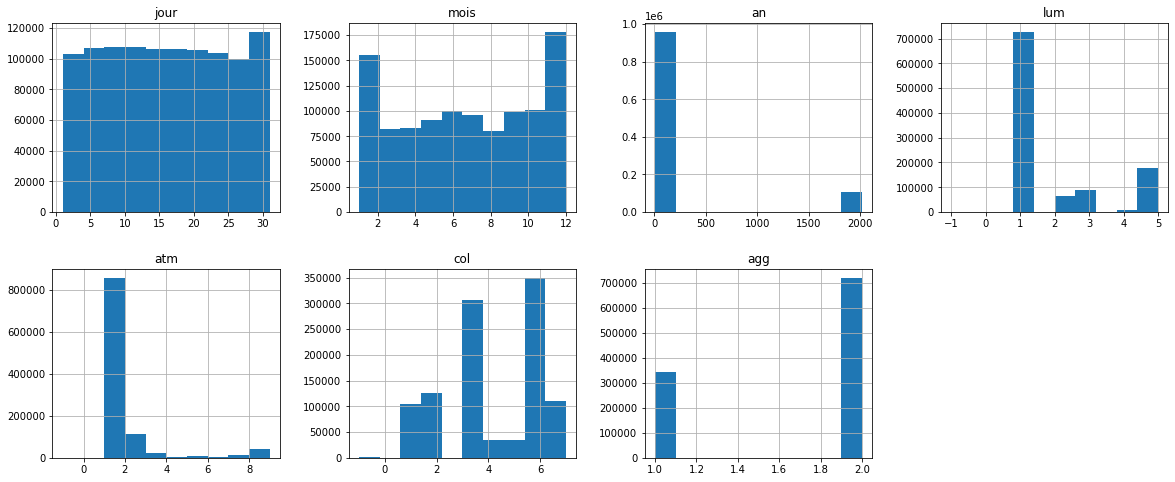

In [9]:
dfCarac[['jour', 'mois', 'an', 'lum', 'atm', 'col', 'agg']].hist(figsize=(20, 8), layout=(2, 4));

### -Table Lieux-

In [15]:
dfLieux.head(3)

,Unnamed: 0.1,Unnamed: 0,Num_Acc,catr,voie,v1,v2,circ,nbv,pr,...,prof,plan,lartpc,larrout,surf,infra,situ,env1,vma,grav
0,0,0,201600000001,3.0,39,NaN,NaN,2.0,0.0,NaN,...,1.0,3.0,0.0,0.0,1.0,0.0,1.0,0.0,NaN,3
1,1,1,201600000002,3.0,39,NaN,NaN,1.0,0.0,NaN,...,1.0,2.0,0.0,58.0,1.0,0.0,1.0,0.0,NaN,3
2,2,2,201600000003,3.0,1,NaN,NaN,2.0,2.0,NaN,...,1.0,3.0,0.0,68.0,2.0,0.0,3.0,99.0,NaN,3


In [12]:
dfLieux[['nbv', 'vosp', 'prof', 'pr', 'pr1', 'plan', 'lartpc', 'larrout', 'surf', 'infra', 'situ', 'env1']].describe()

,nbv,vosp,prof,plan,surf,infra,situ,env1
count,1.062322e+06,1.062292e+06,1.063104e+06,1.062772e+06,1.063129e+06,1.059645e+06,1.060083e+06,953029.000000
mean,2.099984e+00,1.342983e-01,1.155437e+00,1.210787e+00,1.260633e+00,4.799305e-01,1.224638e+00,38.230840
std,1.516156e+00,5.621275e-01,6.102975e-01,7.209365e-01,9.412922e-01,1.466913e+00,8.621112e-01,48.059472
min,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,0.000000
25%,2.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000
50%,2.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000
75%,2.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,99.000000
max,9.900000e+01,3.000000e+00,4.000000e+00,4.000000e+00,9.000000e+00,9.000000e+00,8.000000e+00,99.000000


In [16]:
dfLieux.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1065053 entries, 0 to 1065052
Data columns (total 22 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   Unnamed: 0.1  1065053 non-null  int64  
 1   Unnamed: 0    1065053 non-null  int64  
 2   Num_Acc       1065053 non-null  int64  
 3   catr          1065052 non-null  float64
 4   voie          960441 non-null   object 
 5   v1            429229 non-null   float64
 6   v2            46379 non-null    object 
 7   circ          1063479 non-null  float64
 8   nbv           1062322 non-null  float64
 9   pr            589569 non-null   object 
 10  pr1           587750 non-null   object 
 11  vosp          1062292 non-null  float64
 12  prof          1063104 non-null  float64
 13  plan          1062772 non-null  float64
 14  lartpc        902631 non-null   object 
 15  larrout       952212 non-null   object 
 16  surf          1063129 non-null  float64
 17  infra         1059645 non-n

In [11]:
### Proportion of NA by variable
dfLieux.isnull().sum() * 100 / len(dfLieux)

Unnamed: 0.1     0.000000
Unnamed: 0       0.000000
Num_Acc          0.000000
catr             0.000094
voie             9.822234
v1              59.698813
v2              95.645381
circ             0.147786
nbv              0.256419
pr              44.644163
pr1             44.814953
vosp             0.259236
prof             0.182996
plan             0.214168
lartpc          15.250133
larrout         10.594872
surf             0.180648
infra            0.507768
situ             0.466643
env1            10.518162
vma             89.992611
grav             0.000000
dtype: float64

In [58]:
# Unique modalities by variable
print('nbv:', len(dfLieux.nbv.value_counts()))
print('vosp:', len(dfLieux.vosp.value_counts()))
print('prof:', len(dfLieux.vosp.value_counts()))
print('plan:', len(dfLieux.plan.value_counts()))
print('pr:', len(dfLieux.pr.value_counts()))
print('pr1:', len(dfLieux.pr1.value_counts()))
print('lartpc:', len(dfLieux.lartpc.value_counts()))
print('larrout:', len(dfLieux.larrout.value_counts()))
print('surf:', len(dfLieux.surf.value_counts()))
print('infra:', len(dfLieux.infra.value_counts()))
print('situ:', len(dfLieux.situ.value_counts()))
print('env1:', len(dfLieux.env1.value_counts()))

nbv: 54
vosp: 5
prof: 5
plan: 6
pr: 1472
pr1: 3733
lartpc: 451
larrout: 692
surf: 11
infra: 11
situ: 9
env1: 3


In [59]:
# Values by variable
print(dfLieux.nbv.value_counts())
print(dfLieux.vosp.value_counts())
print(dfLieux.prof.value_counts())
print(dfLieux.plan.value_counts())
print(dfLieux.pr.value_counts())
print(dfLieux.pr1.value_counts())
print(dfLieux.lartpc.value_counts())
print(dfLieux.larrout.value_counts())
print(dfLieux.surf.value_counts())
print(dfLieux.infra.value_counts())
print(dfLieux.situ.value_counts())
print(dfLieux.env1.value_counts())

 2.0     600628
 1.0     125816
 0.0     111739
 4.0     102096
 3.0      82852
 6.0      19548
 5.0      11066
 8.0       3994
 7.0       1418
-1.0       1110
 10.0       838
 9.0        417
 20.0       241
 50.0       158
 11.0       120
 12.0       100
 40.0        30
 30.0        27
 13.0        18
 25.0        14
 21.0        11
 26.0         9
 15.0         8
 90.0         7
 14.0         6
 24.0         6
 70.0         5
 22.0         5
 60.0         3
 31.0         3
 45.0         2
 27.0         2
 17.0         2
 16.0         2
 53.0         2
 86.0         1
 91.0         1
 18.0         1
 84.0         1
 39.0         1
 54.0         1
 29.0         1
 62.0         1
 99.0         1
 44.0         1
 42.0         1
 65.0         1
 36.0         1
 41.0         1
 33.0         1
 52.0         1
 76.0         1
 28.0         1
 23.0         1
Name: nbv, dtype: int64
 0.0    992708
 3.0     30159
 1.0     23819
 2.0     14658
-1.0       948
Name: vosp, dtype: int64
 1.0    8137

In [47]:
# Equilibre variables
print(dfLieux.vosp.value_counts(normalize=True))
print(dfLieux.env1.value_counts(normalize=True))

0.0     0.568222
99.0    0.384745
3.0     0.047033
Name: env1, dtype: float64

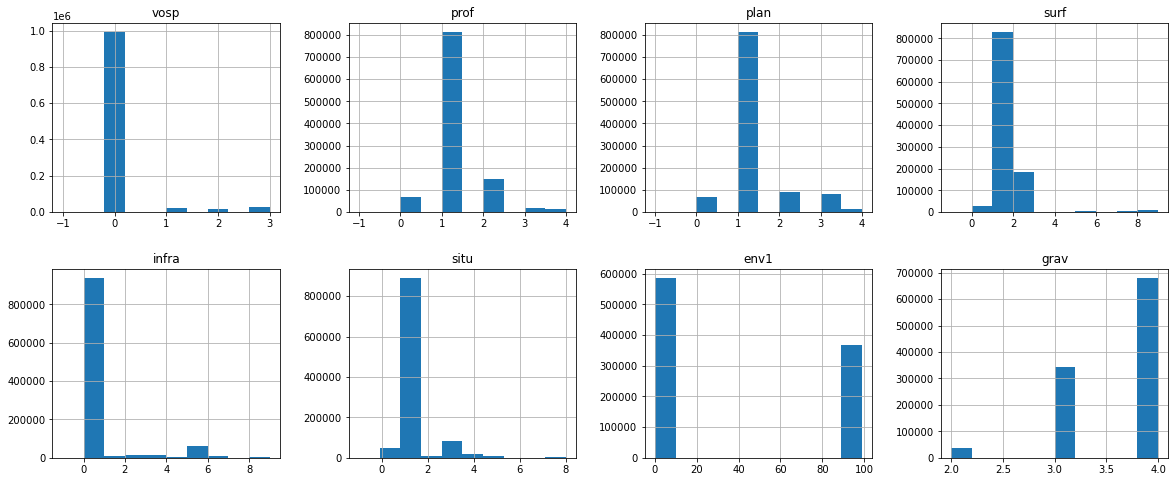

In [10]:
dfLieux[['vosp', 'prof', 'plan', 'surf', 'infra', 'situ', 'env1', 'grav']].hist(figsize=(20, 8), layout=(2, 4));

##### -Table Usagers-

In [20]:
dfUsagers.head(3)

,Unnamed: 0,Num_Acc,place,catu,grav,sexe,trajet,secu,locp,actp,etatp,an_nais,num_veh,id_vehicule,secu1,secu2,secu3
0,0,201600000001,1.0,1,1,2,0.0,11.0,0.0,0.0,0.0,1983.0,B02,NaN,NaN,NaN,NaN
1,1,201600000001,1.0,1,3,1,9.0,21.0,0.0,0.0,0.0,2001.0,A01,NaN,NaN,NaN,NaN
2,2,201600000002,1.0,1,3,1,5.0,11.0,0.0,0.0,0.0,1960.0,A01,NaN,NaN,NaN,NaN


##### -Table Vehicles-

In [21]:
dfVehicules.head(3)

,Unnamed: 0.1,Unnamed: 0,Num_Acc,senc,catv,occutc,obs,obsm,choc,manv,num_veh,id_vehicule,motor,grav
0,0,0,201600000001,0.0,7,0.0,0.0,0.0,1.0,1.0,B02,NaN,NaN,3
1,1,1,201600000001,0.0,2,0.0,0.0,0.0,7.0,15.0,A01,NaN,NaN,3
2,2,2,201600000002,0.0,7,0.0,6.0,0.0,1.0,1.0,A01,NaN,NaN,3


### Graphs

In [22]:
# Gravity variable in Carac dataframe
pd.DataFrame({'prop':dfCarac.grav.value_counts(normalize=True),
              'count':dfCarac.grav.value_counts()})

,prop,count
4,0.639622,681231
3,0.323996,345073
2,0.036382,38749


In [23]:
# Gravity variable in Lieux dataframe
pd.DataFrame({'prop':dfLieux.grav.value_counts(normalize=True),
              'count':dfLieux.grav.value_counts()})

,prop,count
4,0.639622,681231
3,0.323996,345073
2,0.036382,38749


$\color{#0005FF}{\text{Both dataframes Carac and Lieux have the same amount of accidents, they also have the same accident gravity distribution}}$

##### -Table Carac-

### Year

C:\Users\Megaport\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


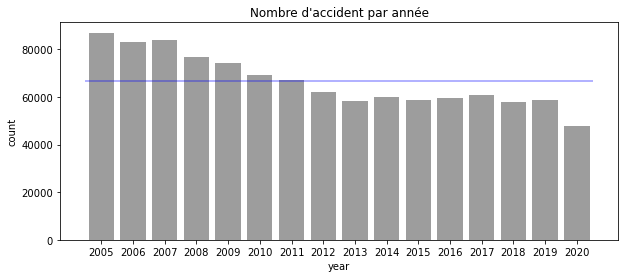

In [73]:
# Display plots
plt.figure(figsize=(10, 4))
sns.countplot(dfCarac['year'], palette=['#9D9D9D'])
plt.hlines(y=len(dfCarac['year'])/16, xmin=-0.5, xmax=15.5, color='blue', alpha=0.4)
plt.title("Nombre d'accident par année");
# It seems that the number of accident never stops decreasing year after year
# The observable large decreases seem to be during 2007-2008, 2011-2012 and 2019-2020
# The number of accident seemed to be stable between 2013 and 2019

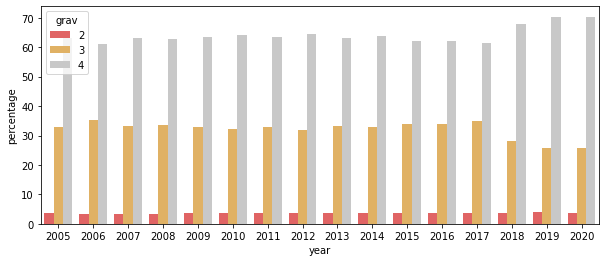

In [25]:
# Initiating dataframe grouped by month
dfCaracGpByYear = (dfCarac.groupby(['year'])['grav']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('grav'))

# Display plotx
fig, ax = plt.subplots(figsize=(10, 4))
sns.barplot(x="year", y="percentage", hue="grav", data=dfCaracGpByYear, 
             palette=['#F45050','#F4B650','#C8C8C8']);
# It seems that the gravity is less important during 2018 to 2020

C:\Users\Megaport\AppData\Local\Temp\ipykernel_15708\854147923.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


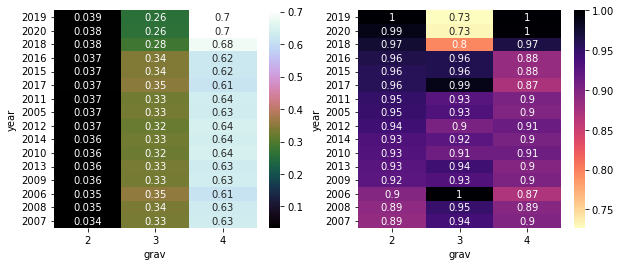

In [26]:
# data-management
dfYearGrav = pd.crosstab(dfCarac['year'], dfCarac['grav'], normalize=0).sort_values(by=2, ascending=False)

# Display plots
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
sns.heatmap(dfYearGrav, annot=True, cmap='cubehelix', ax=ax[0])
sns.heatmap(dfYearGrav.div(dfYearGrav.max(axis=0), axis=1), annot=True, cmap='magma_r', ax=ax[1]);
fig.show()
# Even though 2018 to 2020 have the largest proportions of accident gravity 3, they also have the lowest gravity 3 ones
# It seems that the state has focused on reducing the overall number of accident but not the gravity of accidents

### Months

C:\Users\Megaport\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


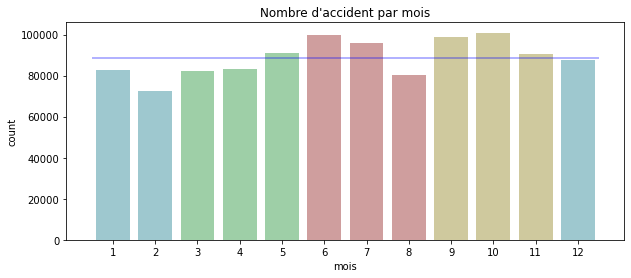

In [72]:
# Display plots
plt.figure(figsize=(10, 4))
sns.countplot(dfCarac['mois'], 
             palette=['#96CED7', '#96CED7', 
                   '#96D7A2', '#96D7A2', '#96D7A2', 
                   '#D79696', '#D79696', '#D79696', 
                   '#D7CF96', '#D7CF96', '#D7CF96', 
                   '#96CED7'])
plt.hlines(y=len(dfCarac['mois'])/12, xmin=-0.5, xmax=11.5, color='blue', alpha=0.4)
plt.title("Nombre d'accident par mois");
# On peut observer que les mois de juin, juillet, septembre et octobre semblent avoir le plus d'accidents
# On peut observer que le mois de février compte le moins d'accidents mais il comporte aussi 28 jours

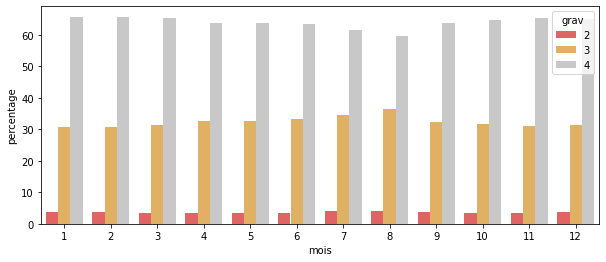

In [28]:
# Initiating dataframe grouped by month
dfCaracGpByMonth = (dfCarac.groupby(['mois'])['grav']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('grav'))

# Display plotx
fig, ax = plt.subplots(figsize=(10, 4))
sns.barplot(x="mois", y="percentage", hue="grav", data=dfCaracGpByMonth, 
             palette=['#F45050','#F4B650','#C8C8C8']);
# It seems that the gravity of accident is larger during the weekend compared to the week

C:\Users\Megaport\AppData\Local\Temp\ipykernel_15708\1167849743.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


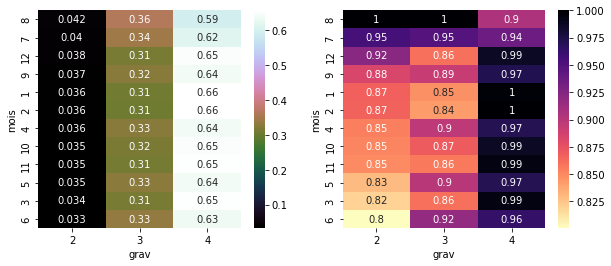

In [29]:
# data-management
dfMonthGrav = pd.crosstab(dfCarac['mois'], dfCarac['grav'], normalize=0).sort_values(by=2, ascending=False)

# Display plots
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
sns.heatmap(dfMonthGrav, annot=True, cmap='cubehelix', ax=ax[0])
sns.heatmap(dfMonthGrav.div(dfMonthGrav.max(axis=0), axis=1), annot=True, cmap='magma_r', ax=ax[1]);
fig.show()
# It seems that the largest proportion of accident gravity 2 & 3 happen during august and july

### Month day

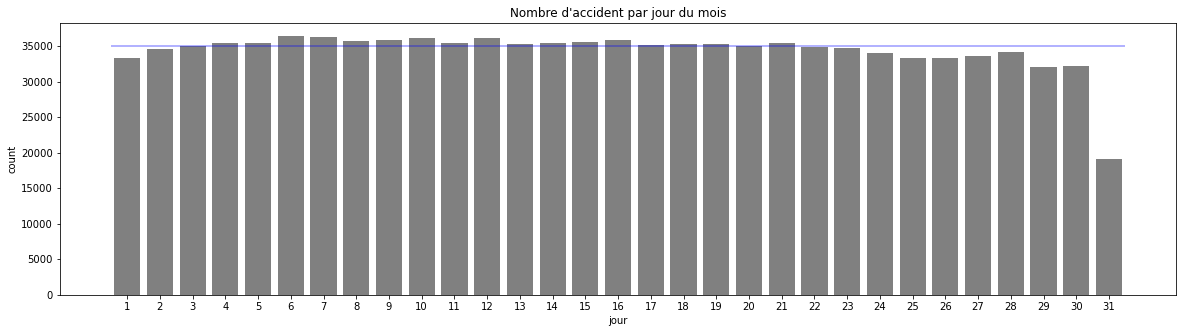

In [29]:
plt.figure(figsize=(20, 5))
sns.countplot(x=dfCarac['jour'], color='grey')
plt.hlines(y=len(dfCarac['jour'])/(365/12), xmin=-0.5, xmax=30.5, color='blue', alpha=0.4)
plt.title("Nombre d'accident par jour du mois");
# With no surprise, day 31 has twice as less accidents as other days of the month because it only occurs 1 months out of 2

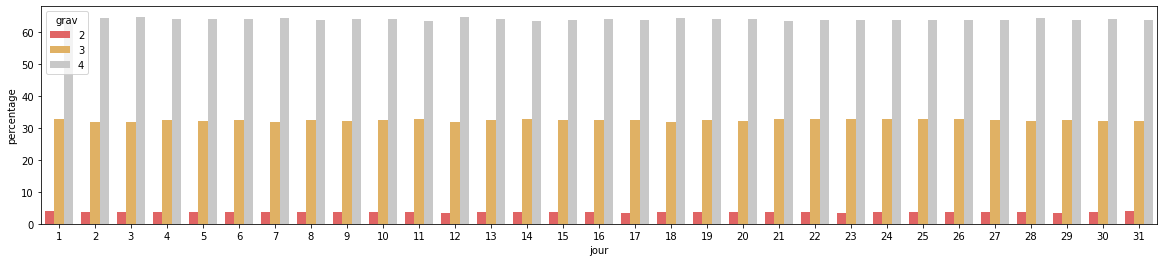

In [31]:
# Initiating dataframe grouped by weekday
dfCaracGpByMonthday = (dfCarac.groupby(['jour'])['grav']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('grav'))

# Display plotx
fig, ax = plt.subplots(figsize=(20, 4))
sns.barplot(x="jour", y="percentage", hue="grav", data=dfCaracGpByMonthday, 
             palette=['#F45050','#F4B650','#C8C8C8']);
# Hard to read this figure but no trend seems to be seen

C:\Users\Megaport\AppData\Local\Temp\ipykernel_19976\698501153.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


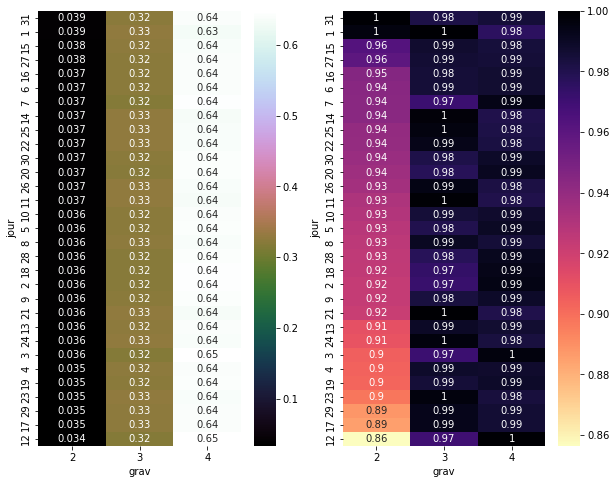

In [33]:
# data-management
dfMonthdayGrav = pd.crosstab(dfCarac['jour'], dfCarac['grav'], normalize=0).sort_values(by=2, ascending=False)

# Display plots
fig, ax = plt.subplots(1, 2, figsize=(10, 8))
sns.heatmap(dfMonthdayGrav, annot=True, cmap='cubehelix', ax=ax[0])
sns.heatmap(dfMonthdayGrav.div(dfMonthdayGrav.max(axis=0), axis=1), annot=True, cmap='magma_r', ax=ax[1]);
fig.show()
# Geniunly no trend drawn

### Weekday

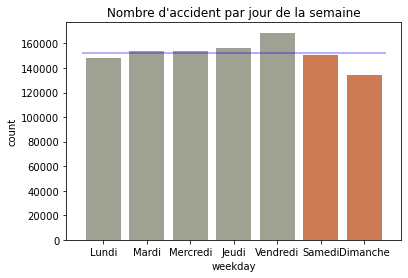

In [30]:
sns.countplot(x=dfCarac['weekday'], 
             palette=['#A0A491', '#A0A491', '#A0A491', '#A0A491', '#A0A491', '#E17441', '#E17441'])
plt.hlines(y=len(dfCarac['weekday'])/7, xmin=-0.5, xmax=6.5, color='blue', alpha=0.4);
plt.xticks(np.arange(7), ['Lundi', 'Mardi', 'Mercredi', 'Jeudi', 'Vendredi', 'Samedi', 'Dimanche'])
plt.title("Nombre d'accident par jour de la semaine");
# It seems that the friday is the accident day

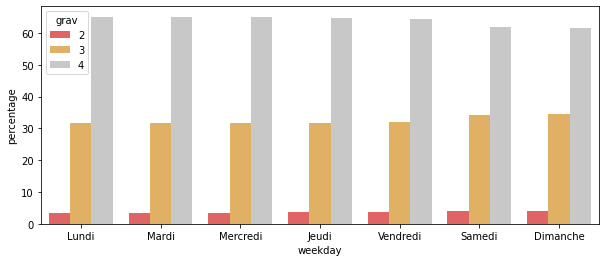

In [31]:
# Initiating dataframe grouped by weekday
dfCaracGpByWeekday = (dfCarac.groupby(['weekday'])['grav']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('grav'))

# Display plotx
fig, ax = plt.subplots(figsize=(10, 4))
sns.barplot(x="weekday", y="percentage", hue="grav", data=dfCaracGpByWeekday, 
             palette=['#F45050','#F4B650','#C8C8C8'])
ax.set_xticklabels(['Lundi', 'Mardi', 'Mercredi', 'Jeudi', 'Vendredi', 'Samedi', 'Dimanche']);
# It seems that the gravity of accident is larger during the weekend compared to the week

C:\Users\Megaport\AppData\Local\Temp\ipykernel_15708\2315118038.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


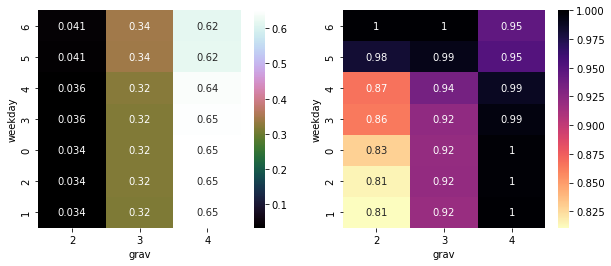

In [32]:
# data-management
dfWeekdayGrav = pd.crosstab(dfCarac['weekday'], dfCarac['grav'], normalize=0).sort_values(by=2, ascending=False)

# Display plots
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
sns.heatmap(dfWeekdayGrav, annot=True, cmap='cubehelix', ax=ax[0])
sns.heatmap(dfWeekdayGrav.div(dfWeekdayGrav.max(axis=0), axis=1), annot=True, cmap='magma_r', ax=ax[1]);
fig.show()
# Actually, the largest proportion of accident gravity 2 is during sunday then saturday

### Hour of the day

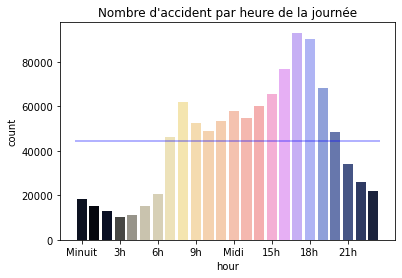

In [33]:
sns.countplot(x=dfCarac['hour'], 
             palette=['#090F23', '#03060F', '#040D29', '#484743', '#999588', '#CDC5A9', 
                     '#DDD3B0', '#F5E7B1', '#FFECA4', '#FFDEA4', '#FFD2A4', '#FFCBA4', 
                     '#FFBDA4', '#FFAFA4', '#FFA4A4', '#FFA4D6', '#EDA4FF', '#C2A4FF', 
                     '#A4AAFF', '#839AE5', '#5B71B8', '#3C508F', '#26366A', '#152043'])
plt.xticks([0, 3, 6, 9, 12, 15, 18, 21], ['Minuit', '3h', '6h', '9h', 'Midi', '15h', '18h', '21h'])
plt.title("Nombre d'accident par heure de la journée")
plt.hlines(y=len(dfCarac['hour'])/24, xmin=-0.5, xmax=23.5, color='blue', alpha=0.4);
# It seems that most accident happen between 4pm and 7pm which is when people usually go back home and the sun goes down
# At 7am, the number of accident drastically increase and really goes down after 8pm

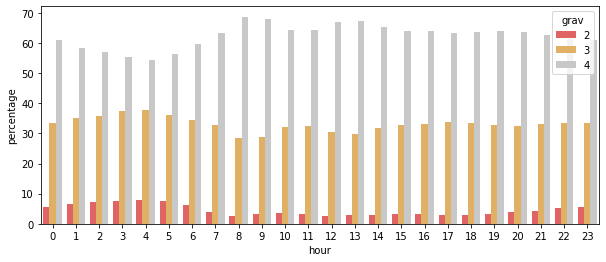

In [34]:
# Initiating dataframe grouped by hour
dfCaracGpByHour = (dfCarac.groupby(['hour'])['grav']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('grav'))

# Display plotx
fig, ax = plt.subplots(figsize=(10, 4))
sns.barplot(x="hour", y="percentage", hue="grav", data=dfCaracGpByHour, 
             palette=['#F45050','#F4B650','#C8C8C8']);
# Wow, it seems that the gravity of accidents is worst during the night (22pm-6am)
# More than 5% gravity 2 during the night against less than 4% during full day

C:\Users\Megaport\AppData\Local\Temp\ipykernel_15708\1640874297.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


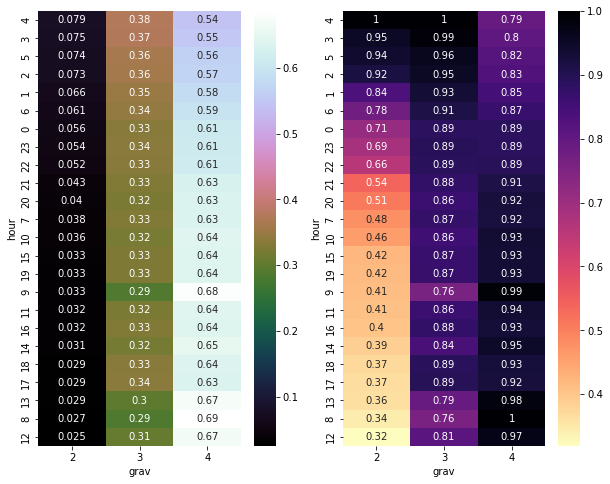

In [35]:
# data-management
dfHourGrav = pd.crosstab(dfCarac['hour'], dfCarac['grav'], normalize=0).sort_values(by=2, ascending=False)

# Display plots
fig, ax = plt.subplots(1, 2, figsize=(10, 8))
sns.heatmap(dfHourGrav, annot=True, cmap='cubehelix', ax=ax[0])
sns.heatmap(dfHourGrav.div(dfHourGrav.max(axis=0), axis=1), annot=True, cmap='magma_r', ax=ax[1]);
fig.show()
# Proposition: creating a full night variable [0-6am] (yes/no)

### Lum

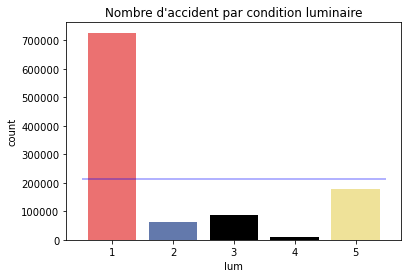

In [74]:
sns.countplot(x=dfCarac['lum'][(dfCarac['lum']!=-1)], 
             palette=['#FF5D5D', '#5774B8', '#000000', '#000000', '#FDEC8B'])
plt.title("Nombre d'accident par condition luminaire")
plt.hlines(y=len(dfCarac['lum'][(dfCarac['lum']!=-1)])/5, xmin=-0.5, xmax=4.5, color='blue', alpha=0.4);
# It seems that most accident happen during the full day

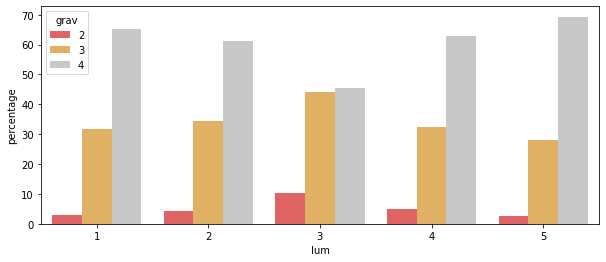

In [77]:
# Initiating dataframe grouped by hour
dfCaracGpByLum = (dfCarac[(dfCarac['lum']!=-1)].groupby(['lum'])['grav']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('grav'))

# Display plotx
fig, ax = plt.subplots(figsize=(10, 4))
sns.barplot(x="lum", y="percentage", hue="grav", data=dfCaracGpByLum, 
             palette=['#F45050','#F4B650','#C8C8C8']);
# Wow, it seems that the gravity of accidents is worst during the night (22pm-6am)
# More than 5% gravity 2 during the night against less than 4% during full day

C:\Users\Megaport\AppData\Local\Temp\ipykernel_15708\3437458070.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


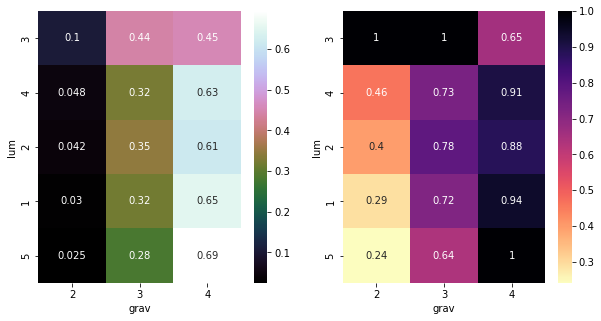

In [97]:
# data-management
dfLumGrav = pd.crosstab(dfCarac['lum'][(dfCarac['lum']!=-1)], dfCarac['grav'][(dfCarac['lum']!=-1)], normalize=0).sort_values(by=2, ascending=False)

# Display plots
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.heatmap(dfLumGrav, annot=True, cmap='cubehelix', ax=ax[0])
sns.heatmap(dfLumGrav.div(dfLumGrav.max(axis=0), axis=1), annot=True, cmap='magma_r', ax=ax[1]);
fig.show()
# The night without public lightning seems to have a drastic increase of gravity 2 and 3 accidents rate (10% and 44%)!
# Then the two other cases where no much light is on have interesting gravity 2 increase accident rates

### Atm

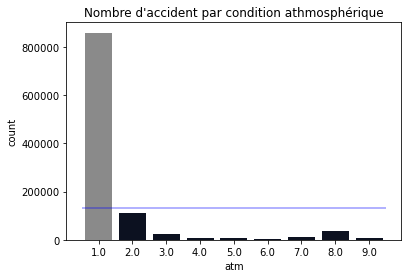

In [94]:
sns.countplot(x=dfCarac['atm'][(dfCarac['atm']!=-1)], 
             palette=['#8A8A8A', '#090F23', '#090F23', '#090F23', '#090F23', '#090F23', 
                     '#090F23', '#090F23', '#090F23'])
plt.title("Nombre d'accident par condition athmosphérique")
plt.hlines(y=len(dfCarac['atm'][(dfCarac['atm']!=-1)])/8, xmin=-0.5, xmax=8.5, color='blue', alpha=0.4);
# It seems that most accident happen with normal atmospheric conditions, then light rain

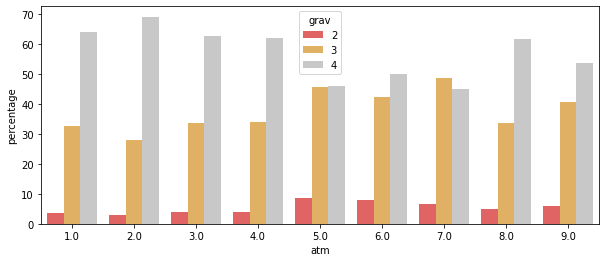

In [84]:
# Initiating dataframe grouped by hour
dfCaracGpByAtm = (dfCarac[(dfCarac['atm']!=-1)].groupby(['atm'])['grav']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('grav'))

# Display plotx
fig, ax = plt.subplots(figsize=(10, 4))
sns.barplot(x="atm", y="percentage", hue="grav", data=dfCaracGpByAtm, 
             palette=['#F45050','#F4B650','#C8C8C8']);
# Wow, it seems that the gravity of accidents is worst during fog/smoke, strong wind/storm, dazzling weather and 'other'

C:\Users\Megaport\AppData\Local\Temp\ipykernel_15708\106443342.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


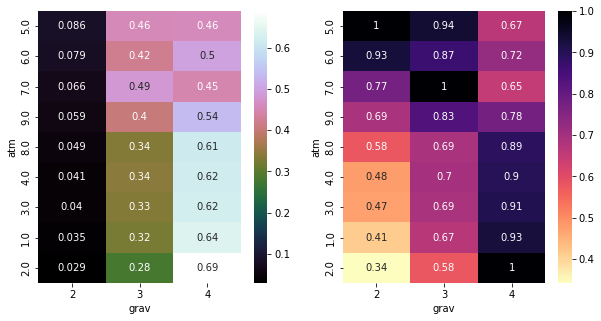

In [96]:
# data-management
dfAtmGrav = pd.crosstab(dfCarac['atm'][(dfCarac['atm']!=-1)], dfCarac['grav'][(dfCarac['atm']!=-1)], normalize=0).sort_values(by=2, ascending=False)

# Display plots
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.heatmap(dfAtmGrav, annot=True, cmap='cubehelix', ax=ax[0])
sns.heatmap(dfAtmGrav.div(dfAtmGrav.max(axis=0), axis=1), annot=True, cmap='magma_r', ax=ax[1]);
fig.show()
# These graphs confirm that both gravity 2 and 3 are increase for groups 5, 6, 7 and 9

### Col

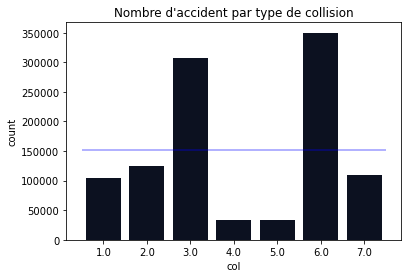

In [89]:
sns.countplot(x=dfCarac['col'][(dfCarac['col']!=-1)], 
             palette=['#090F23', '#090F23', '#090F23', '#090F23', '#090F23', '#090F23', '#090F23'])
plt.title("Nombre d'accident par type de collision")
plt.hlines(y=len(dfCarac['col'][(dfCarac['col']!=-1)])/7, xmin=-0.5, xmax=6.5, color='blue', alpha=0.4);
# Other collision and by the side are the most counted
# It is quite disturbing to see that the most filled class is the group 'other'
# There is a feeling that this variable was not well defined or filled

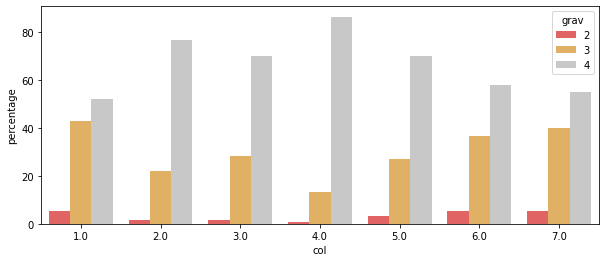

In [90]:
# Initiating dataframe grouped by hour
dfCaracGpByCol = (dfCarac[(dfCarac['col']!=-1)].groupby(['col'])['grav']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('grav'))

# Display plotx
fig, ax = plt.subplots(figsize=(10, 4))
sns.barplot(x="col", y="percentage", hue="grav", data=dfCaracGpByCol, 
             palette=['#F45050','#F4B650','#C8C8C8']);
# Les groupes 2, 3 et 4 sont très peu impactés en termes de gravité alors que les groupes 1, 6 et 7 semblent impactants

C:\Users\Megaport\AppData\Local\Temp\ipykernel_15708\3981302610.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


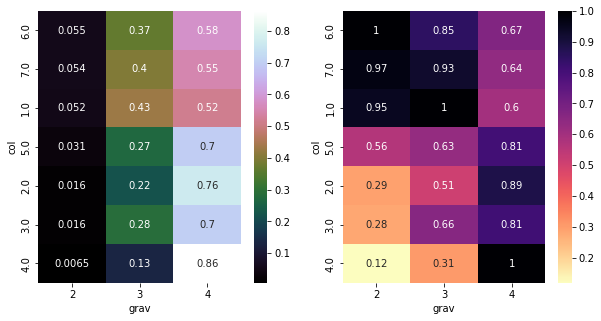

In [95]:
# data-management
dfColGrav = pd.crosstab(dfCarac['col'][(dfCarac['col']!=-1)], dfCarac['grav'][(dfCarac['col']!=-1)], normalize=0).sort_values(by=2, ascending=False)

# Display plots
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.heatmap(dfColGrav, annot=True, cmap='cubehelix', ax=ax[0])
sns.heatmap(dfColGrav.div(dfColGrav.max(axis=0), axis=1), annot=True, cmap='magma_r', ax=ax[1]);
fig.show()
# La collision de type 1 est celle qui maximise les accidents de gravité 3 avec un fort taux de gravité 2
# Les collisions de type 6 et 7 sont celles qui maximisent les accidents de gravité 2

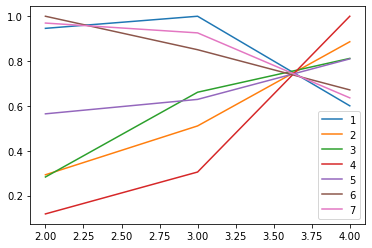

In [57]:
# To update
for i in np.arange(1, 8):
    plt.plot(dfColGrav.div(dfColGrav.max(axis=0), axis=1).loc[i], label=i)
plt.legend();

### nbv

In [78]:
dfLieux.nbv[(dfLieux.nbv<8) & (dfLieux.nbv>-1)].value_counts()

2.0    600628
1.0    125816
0.0    111739
4.0    102096
3.0     82852
6.0     19548
5.0     11066
7.0      1418
Name: nbv, dtype: int64

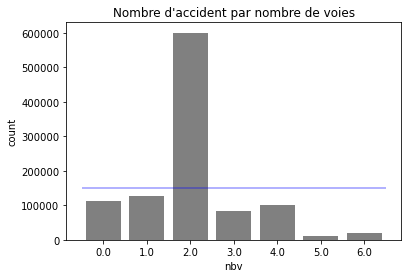

In [83]:
sns.countplot(x=dfLieux.nbv[(dfLieux.nbv<7) & (dfLieux.nbv>-1)], color='grey')
plt.title("Nombre d'accident par nombre de voies")
plt.hlines(y=len(dfLieux['nbv'][(dfLieux.nbv<7) & (dfLieux.nbv>-1)])/7, xmin=-0.5, xmax=6.5, color='blue', alpha=0.4);
# Many accidents when there are 2 route tracks

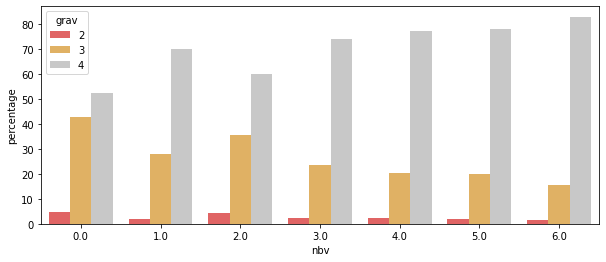

In [88]:
# Initiating dataframe grouped by hour
dfCaracGpByNbv = (dfLieux[(dfLieux.nbv<7) & (dfLieux.nbv>-1)].groupby(['nbv'])['grav']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('grav'))

# Display plotx
fig, ax = plt.subplots(figsize=(10, 4))
sns.barplot(x="nbv", y="percentage", hue="grav", data=dfCaracGpByNbv, 
             palette=['#F45050','#F4B650','#C8C8C8']);
# Les groupes 0 et 2 semblent avoir un taux élevé d'accidents gravité 2 et 3

C:\Users\Megaport\AppData\Local\Temp\ipykernel_19976\2890361727.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


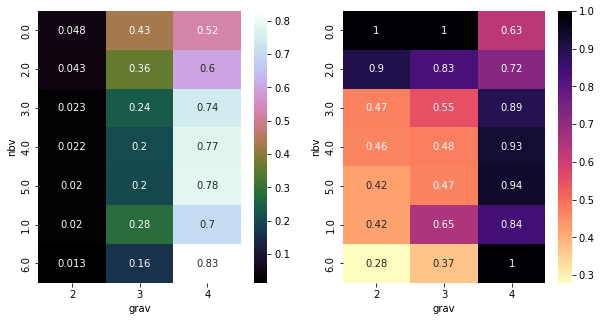

In [84]:
# data-management
dfNbvGrav = pd.crosstab(dfLieux.nbv[(dfLieux.nbv<7) & (dfLieux.nbv>-1)], dfCarac['grav'][(dfLieux.nbv<7) & (dfLieux.nbv>-1)], normalize=0).sort_values(by=2, ascending=False)

# Display plots
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.heatmap(dfNbvGrav, annot=True, cmap='cubehelix', ax=ax[0])
sns.heatmap(dfNbvGrav.div(dfNbvGrav.max(axis=0), axis=1), annot=True, cmap='magma_r', ax=ax[1]);
fig.show()
# Les groupes 0 et 2 semblent avoir un taux élevé d'accidents gravité 2 et 3

### vosp

In [ ]:
# cat


### prof

In [ ]:
cat

### plan

In [ ]:
cat

### pr

In [ ]:
# cat


### pr1

In [ ]:
num

# Boxplots by gravity level
sns.catplot(y='nbv', x='grav', data=dfLieux, kind='box')
sns.catplot(y='nbv', x='grav', data=dfLieux, kind='box')
plt.yscale('log');

### lartpc

In [ ]:
num

### larrout

In [ ]:
num

### surf

In [63]:
cat

# print(dfLieux.surf.value_counts())
# print(dfLieux.infra.value_counts())
# print(dfLieux.situ.value_counts())
# print(dfLieux.env1.value_counts())

 1.0    829791
 2.0    183659
 0.0     29139
 7.0      6446
 9.0      5742
 5.0      3087
 8.0      2577
 3.0      1508
 6.0       608
 4.0       531
-1.0        41
Name: surf, dtype: int64
 0.0    938199
 5.0     62673
 3.0     16361
 2.0     15423
 1.0      9440
 6.0      7308
 9.0      4072
 4.0      3770
-1.0       923
 8.0       837
 7.0       639
Name: infra, dtype: int64
 1.0    890976
 3.0     84281
 0.0     47458
 4.0     18058
 2.0      7711
 5.0      7594
 8.0      2817
 6.0      1061
-1.0       127
Name: situ, dtype: int64
0.0     541532
99.0    366673
3.0      44824
Name: env1, dtype: int64


### infra

In [ ]:
cat

### situ

In [ ]:
cat

### env1

In [ ]:
cat

### XXX

### XXX

### XXX